

Objective
---------
Build intuition for why non-linearities are essential in neural networks.

This notebook shows that:
- A purely linear model cannot solve non-linearly separable problems.
- Adding a non-linear activation allows the model to bend the input space.
- A simple MLP (linear layers + ReLU) can represent and learn non-linear decision boundaries.

Scope
-----
- Focus on forward pass intuition and qualitative behavior.
- Training is implemented in a minimal, numpy-based way.
- No formal backprop derivations or mathematical proofs.

Takeaway
--------
Deep learning works by composing linear transformations with non-linearities.
Without non-linearity, depth is useless.


In [20]:
import numpy as np
import matplotlib.pyplot as plt

## 1 — Non-Linearly Separable Data

We generate a 2D binary classification problem where class membership depends on distance from the origin: `y = 1 if x0^2 + x1^2 > 1.5`. The decision boundary is a circle — impossible for any linear model to represent.

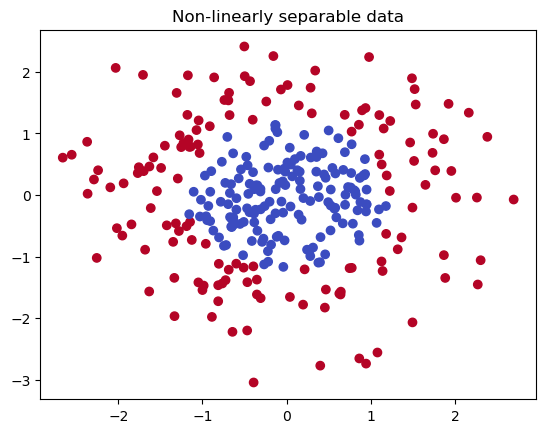

In [21]:
#Generate synthetic non linear data
np.random.seed(0) 
n = 300
X = np.random.randn(n, 2)

y = (X[:, 0]**2 + X[:, 1]**2 > 1.5).astype(float).reshape(-1, 1)

plt.scatter(X[:,0], X[:,1], c=y.squeeze(), cmap="coolwarm")
plt.title("Non-linearly separable data")
plt.show()


## 2 — Linear Model Failure

A linear model can only draw a straight line through this space. No matter how we orient the line, it will misclassify a large portion of the data. This is the fundamental limitation that motivates non-linearity.

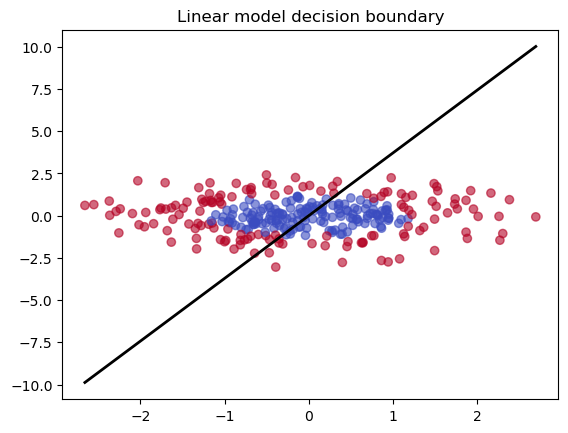

In [22]:
# Let's try a linear model on this data (it will fail)

W = np.random.randn(2, 1)
b = 0.0

def linear_model(X):
    return X @ W + b

z = linear_model(X)
plt.scatter(X[:,0], X[:,1], c=y.squeeze(), cmap="coolwarm", alpha=0.6)

x1 = np.linspace(X[:,0].min(), X[:,0].max(), 100)
x2 = -(W[0] * x1 + b) / W[1]

plt.plot(x1, x2, color="black", linewidth=2)
plt.title("Linear model decision boundary")
plt.show()

## 3 — ReLU Activation

`ReLU(z) = max(0, z)` is the simplest non-linear activation. It zeroes out negative values and passes positive values through unchanged. When placed between linear layers, it allows the network to bend the decision boundary.

In [ ]:
def relu(z):
    """ReLU activation: returns max(0, z) element-wise."""
    return np.maximum(0, z)

z = np.linspace(-3, 3, 200)
plt.plot(z, relu(z))
plt.title("ReLU activation function")
plt.xlabel("z")
plt.ylabel("ReLU(z)")
plt.show()

## 4 — MLP Forward Pass

We build a minimal two-layer MLP: `h = ReLU(X @ W1 + b1)`, then `y_hat = h @ W2 + b2`. The hidden layer has 8 units — enough to approximate the circular boundary.

In [ ]:
W1 = np.random.randn(2, 8)
b1 = np.zeros((1, 8))

W2 = np.random.randn(8, 1)
b2 = 0.0

def mlp_forward(X):
    """Forward pass: hidden layer with ReLU, then linear output."""
    h = relu(X @ W1 + b1)
    y_hat = h @ W2 + b2
    return y_hat

## 5 — Training: Backpropagation from Scratch

We train both the linear model and the MLP side by side for 1000 epochs using MSE loss and manual gradient computation. The key function is `compute_gradients_mlp`, which implements the chain rule through both layers:

1. Compute `dL/dy_hat` (loss gradient)
2. Backprop through output layer → `dW2, db2`
3. Backprop through ReLU → mask out gradients where pre-activation was negative
4. Backprop through hidden layer → `dW1, db1`

In [ ]:
def mse_loss(y, y_hat):
    """Mean squared error loss."""
    return np.mean((y - y_hat)**2)

def relu_grad(z):
    """Derivative of ReLU: 1 where z > 0, else 0."""
    return (z > 0).astype(float)

def compute_gradients_linear(X, y, y_hat):
    """Gradients of MSE w.r.t. a single linear layer (W, b)."""
    m = y.shape[0]
    dL_dyhat = -2 * (y - y_hat) / m
    dL_dW = X.T @ dL_dyhat
    dL_db = np.sum(dL_dyhat, axis=0)
    return dL_dW, dL_db

def compute_gradients_mlp(X, y, y_hat):
    """Backpropagation through the two-layer MLP. Returns gradients for all four parameter groups."""
    m = y.shape[0]
    
    h = relu(X @ W1 + b1)
    
    # Output layer gradients
    dL_dyhat = -2 * (y - y_hat) / m
    dL_dW2 = h.T @ dL_dyhat
    dL_db2 = np.sum(dL_dyhat, axis=0)
    
    # Hidden layer gradients (chain rule through ReLU)
    dL_dh = dL_dyhat @ W2.T
    dL_dz1 = dL_dh * relu_grad(X @ W1 + b1)
    dL_dW1 = X.T @ dL_dz1
    dL_db1 = np.sum(dL_dz1, axis=0)
    
    return dL_dW1, dL_db1, dL_dW2, dL_db2

def update_parameters_linear(W, b, dW, db, lr):
    W -= lr * dW
    b -= lr * db
    return W, b

def update_parameters_mlp(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    return W1, b1, W2, b2

lr = 0.01
n_epochs = 1000
losses_mlp = []
losses_linear = []

for epoch in range(n_epochs):
    y_mlp_hat = mlp_forward(X)
    y_linear_hat = linear_model(X)
    loss_linear = mse_loss(y, y_linear_hat)
    loss_mlp = mse_loss(y, y_mlp_hat)
    losses_mlp.append(loss_mlp)
    losses_linear.append(loss_linear)
    dW1, db1, dW2, db2 = compute_gradients_mlp(X, y, y_mlp_hat)
    dW, db = compute_gradients_linear(X, y, y_linear_hat)
    W1, b1, W2, b2 = update_parameters_mlp(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)
    W, b = update_parameters_linear(W, b, dW, db, lr)
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_mlp:.4f}, Linear Loss: {loss_linear:.4f}")

plt.figure(figsize=(6,4))
plt.plot(losses_linear, label="Linear model")
plt.plot(losses_mlp, label="MLP (ReLU)")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.yscale("log")
plt.legend()
plt.title("Training loss comparison (log scale)")
plt.show()

## Takeaway\n\n- A linear model is stuck at MSE ~0.25 because it cannot draw a curved decision boundary.\n- The MLP (linear + ReLU + linear) reaches MSE ~0.001 — it learns to approximate the circle.\n- The only structural difference is one `ReLU` call between two linear layers.\n- **Without non-linearity, depth is useless** — stacking linear layers collapses to a single linear transformation.\n- Notebook 03 applies this idea to a real image classification task using PyTorch.